# Monte Carlo Simulation


In [1]:
# Compile C source codes
!gcc -Wall MonteCarloSampling.c -o MonteCarloSampling.o -lm

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# CONSTANTS
critical_temperature = 2/( np.log( np.sqrt(2)+1) )

# FUNCTIONS
def generate_data(lowest_temperature, increment_temperature, highest_temperature,
                  lattice_side, number_of_configurations, number_of_thermalisation_steps,
                  filename='data.csv', clear_old_data=True, show_termalisation_info=False):

  debug_flag = "" if show_termalisation_info else "1>/dev/null"
  clear_flag = f"rm -rf {filename}" if clear_old_data else ""

  sh = f"""
  set -e
  export LC_NUMERIC="en_US.UTF-8"

  {clear_flag}

  for T in $(seq {lowest_temperature} {increment_temperature} {highest_temperature})
  do
    ./MonteCarloSampling.o --lattice-side {lattice_side} \
                          --temperature $T \
                          --number-of-configurations {number_of_configurations} \
                          --thermalisation-steps {number_of_thermalisation_steps} \
                          --output-file '{filename}' {debug_flag}
  done
  """
  with open('script.sh', 'w') as file:
    file.write(sh)

  !bash script.sh && rm script.sh


def dataframe_from_lattice_csv(fileName, lattice_side):
    df = pd.read_csv(fileName, names=['L', 'T', 'E']+['LP'+str(i) for i in range(lattice_side*lattice_side)] )

    df['lattice'] = df[df.columns[3:]].apply( lambda x: np.array(x), axis=1)
    df = df.drop(columns=['L']+['LP'+str(i) for i in range(lattice_side*lattice_side)])
    df['magnetization']  = df['lattice'].apply(lambda x: x.sum()/x.shape[0])

    return df

In [3]:
lowest_temperature = 1 
highest_temperature = 3.5 
increment_temperature = 0.02
lattice_side = 8
number_of_configurations = 250
number_of_thermalisation_steps = 1000

filename = "magnetization_data.csv"

# generate_data(lowest_temperature, increment_temperature, highest_temperature,
#               lattice_side, number_of_configurations, number_of_thermalisation_steps,
#               filename, clear_old_data=True, show_termalisation_info=False)

print(f"Data Generation completed. The files are available in {filename}.")

Data Generation completed. The files are available in magnetization_data.csv.


Plot of the configurations with average positive and negative magnetization. Hue is linked to the energy of the configuration.

/home/david/anaconda3/envs/ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/david/anaconda3/envs/ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/david/anaconda3/envs/ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/david/anaconda3/envs/ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

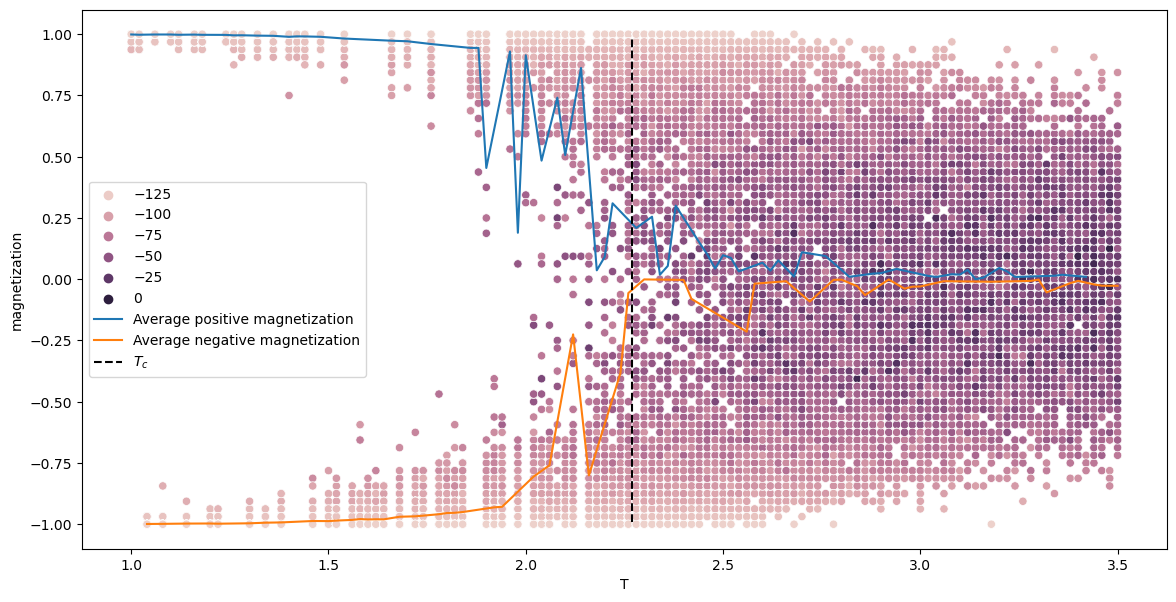

In [4]:
df = dataframe_from_lattice_csv('magnetization_data.csv', lattice_side)

# Compute average magnetization
T_unique_vector = np.unique(df['T'])
magnetization_at_T = np.empty( T_unique_vector.shape[0] )

for i, T_uniq in enumerate(T_unique_vector):
    mask_T_uniq = df['T'] == T_uniq
    df_magnetization_at_T_uniq = df[mask_T_uniq]['magnetization']
    magnetization_at_T[i] = df_magnetization_at_T_uniq.sum() / df_magnetization_at_T_uniq.shape[0]

positive_magnetization_mask = magnetization_at_T>0


# Plot the magnetization with the corresponding energy and critical temperature
fig, ax = plt.subplots(figsize=(14,7))
sns.scatterplot(x=df['T'], y=df['magnetization'],
                hue=df['E'], ax=ax)

sns.lineplot(x=T_unique_vector[positive_magnetization_mask],
             y=magnetization_at_T[positive_magnetization_mask],
             label="Average positive magnetization", ax=ax)
sns.lineplot(x=T_unique_vector[~positive_magnetization_mask],
             y=magnetization_at_T[~positive_magnetization_mask],
             label="Average negative magnetization", ax=ax)

plt.axvline(critical_temperature, 0.05, 0.95, label=r"$T_c$",
            color="k", linestyle='dashed');
plt.legend()
plt.show();